# Future clade frequencies by initial or delta frequency

Use a 12 year H3N2 HA tree to track the fates of clades in one year based on their initial frequencies. Repeat to find fates of clades in one year based on their delta frequency from the recent past.

Start by downloading the tree from Nextstrain.

In [100]:
from augur.frequency_estimators import TreeKdeFrequencies
from augur.utils import json_to_tree
import gzip
import urllib
import json
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%matplotlib inline
sns.set_style("ticks")
plt.style.use("huddlej")

In [194]:
min_tips_per_clade = 5
delta_time = 1.0
delta_months = 12
delta_past_months = 3

In [204]:
path = "http://data.nextstrain.org/flu_seasonal_h3n2_ha_12y_tree.json"
path = "https://raw.githubusercontent.com/neherlab/allflu/master/auspice/allflu_h3n2_ha_tree.json"
tree_file, http_message = urllib.request.urlretrieve(path)

In [206]:
with open(tree_file, "r") as fh:
    tree_json = json.load(fh)

In [205]:
with gzip.GzipFile(tree_file) as fh:
    tree_json = json.load(fh)

OSError: Not a gzipped file (b'{"')

In [207]:
tree = json_to_tree(tree_json)

In [208]:
tree

Clade(branch_length=0, clade=5617, name='NODE_0003166', numdate=1967.9676919349781, strain='NODE_0003166', yvalue=3115.417561634661)

Estimate frequencies for all nodes in the tree at one month intervals.

In [211]:
kde_frequencies = TreeKdeFrequencies(
    sigma_narrow=3 / 12.0,
    sigma_wide=0.0,
    include_internal_nodes=True
)
frequencies = kde_frequencies.estimate(tree)

Plot clade trajectories for all clades with enough tips.

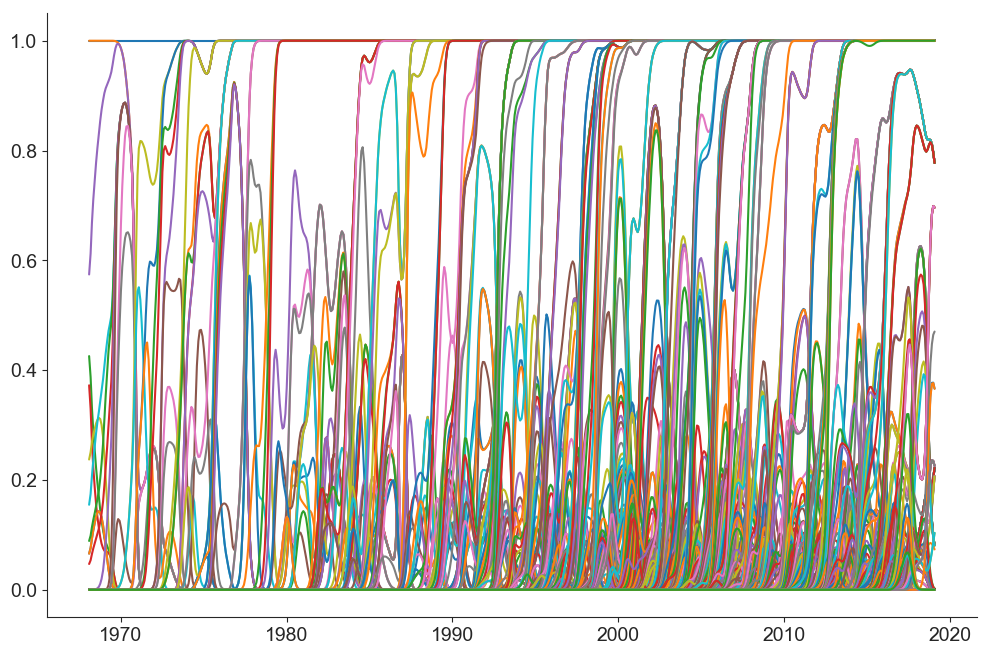

In [212]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
for node in tree.find_clades(terminal=False):
    if node.count_terminals() >= min_tips_per_clade:
        ax.plot(kde_frequencies.pivots, frequencies[node.name])

For all internal nodes, walk through their frequencies using each timepoint as an initial frequency and the frequency delta time into the future as the observed future frequency for all possible values of the initial frequency.

In [213]:
initial_frequency = []
final_frequency = []
total_pivots = len(kde_frequencies.pivots)

for node in tree.find_clades(terminal=False):
    if node.count_terminals() >= min_tips_per_clade:
        for i, pivot in enumerate(kde_frequencies.pivots):
            # Process only clades with initial frequencies between 0 and 1
            # and with a future frequency estimate delta months into the future.
            if frequencies[node.name][i] > 0.01 and frequencies[node.name][i] < 0.99 and i + delta_months < total_pivots:
                initial_frequency.append(frequencies[node.name][i])
                final_frequency.append(frequencies[node.name][i + delta_months])

In [214]:
len(initial_frequency)

29179

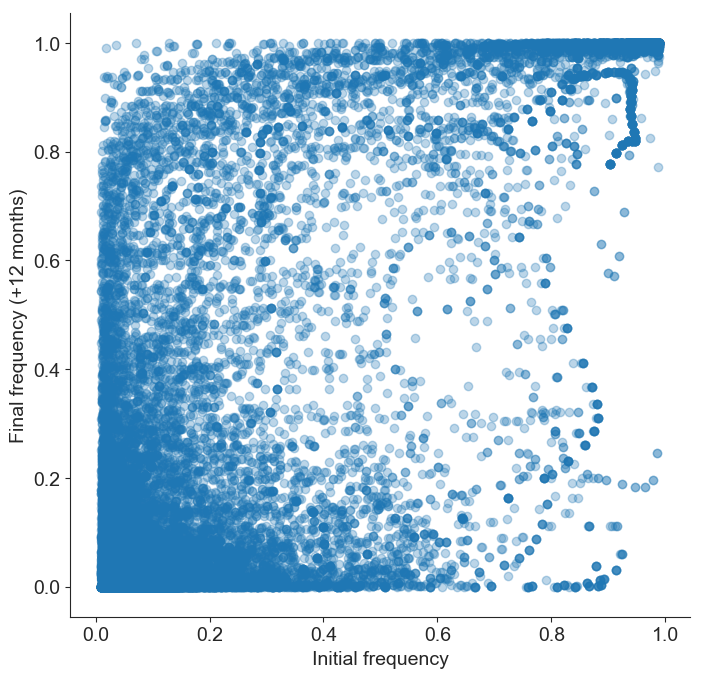

In [215]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(initial_frequency, final_frequency, alpha=0.3)
ax.set_xlabel("Initial frequency")
ax.set_ylabel("Final frequency (+%i months)" % delta_months)
sns.despine()

Repeat the same analysis using the last n months to calculate the delta frequency.

In [216]:
delta_frequency = []
final_frequency_for_delta_frequency = []
total_pivots = len(kde_frequencies.pivots)

for node in tree.find_clades(terminal=False):
    if node.count_terminals() >= min_tips_per_clade:
        for i, pivot in enumerate(kde_frequencies.pivots):
            # Process only clades with initial frequencies between 0 and 1
            # and with a future frequency estimate delta months into the future
            # and with at least delta past months in the past to compare with.
            if (i >= delta_past_months and frequencies[node.name][i] > 0.01 and frequencies[node.name][i] < 0.99 and
                i + delta_months < total_pivots):
                delta_frequency.append(frequencies[node.name][i] - frequencies[node.name][i - delta_past_months])
                final_frequency_for_delta_frequency.append(frequencies[node.name][i + delta_months])

In [217]:
len(delta_frequency)

29152

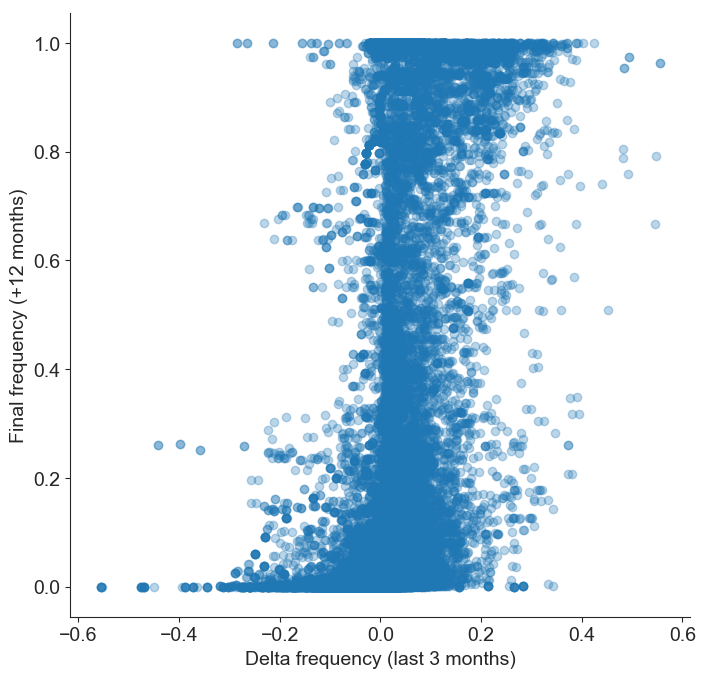

In [218]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(delta_frequency, final_frequency_for_delta_frequency, alpha=0.3)
ax.set_xlabel("Delta frequency (last %i months)" % delta_past_months)
ax.set_ylabel("Final frequency (+%i months)" % delta_months)
sns.despine()

In [219]:
delta_frequency_for_product = []
total_pivots = len(kde_frequencies.pivots)
for node in tree.find_clades(terminal=False):
    if node.count_terminals() >= min_tips_per_clade:
        for i, pivot in enumerate(kde_frequencies.pivots):
            # Process only clades with initial frequencies between 0 and 1
            # and with a future frequency estimate delta months into the future
            # and with at least delta past months in the past to compare with.
            if (i >= delta_past_months and frequencies[node.name][i] > 0.01 and frequencies[node.name][i] < 0.99 and
                i + delta_months < total_pivots):
                frequency_product = frequencies[node.name][i] * (1 - frequencies[node.name][i])
                delta_frequency = frequencies[node.name][i] - frequencies[node.name][i - delta_past_months]
                
                delta_frequency_for_product.append([frequencies[node.name][i-delta_past_months], 
                                                    frequencies[node.name][i], 
                                                    frequencies[node.name][i+delta_months]])


In [220]:
delta_frequency_for_product = np.array(delta_frequency_for_product)

In [221]:
len(delta_frequency_for_product)

29152

In [222]:
delta_frequency_for_product[:10]

array([[0.99809622, 0.98638041, 0.24561665],
       [0.99606661, 0.97777679, 0.19589031],
       [0.99234793, 0.96457371, 0.18258324],
       [0.98638041, 0.94664204, 0.18329335],
       [0.97777679, 0.92489565, 0.18827426],
       [0.96457371, 0.89661166, 0.19594043],
       [0.94664204, 0.86272005, 0.20616712],
       [0.92489565, 0.82451975, 0.21861864],
       [0.89661166, 0.7712897 , 0.2338245 ],
       [0.86272005, 0.68657985, 0.2481713 ]])

0.0 -1 -0.07662043422381486 746 0.8050149080926838
0.2 -1 -0.20171769921974214 382 0.9450398613260115
0.4 -1 -0.3394537309515701 140 1.0116474284230144
0.6000000000000001 -1 -0.4259839710634221 66 1.8203337173464846
0.0 -0.1 -0.05414281528565597 1896 1.2579288038652854
0.2 -0.1 -0.19153871645498166 227 0.7902991176058557
0.4 -0.1 -0.2273320859070504 79 1.2956444631192874
0.6000000000000001 -0.1 -0.4468711835331361 38 1.6194006648187622
0.0 -0.05 0.029711921892619765 15317 6.635330479856237
0.2 -0.05 -0.04311242635763446 1012 1.5502923519055578
0.4 -0.05 -0.284660055809021 263 1.0585746117911736
0.6000000000000001 -0.05 -0.05787779551807507 240 1.8869523900414844
0.0 0.05 0.11080031634137498 2247 2.987434751336677
0.2 0.05 0.0399791873486056 668 1.7497470543496039
0.4 0.05 -0.1404686135588794 169 1.4178506416867387
0.6000000000000001 0.05 0.0395248016520044 180 1.3466958340334105
0.0 0.1 0.18193622711061816 411 2.3510820698909467
0.2 0.1 0.17888229874509654 1028 1.7799516130982078
0.4 0

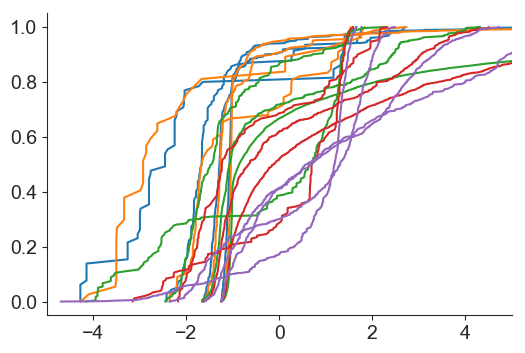

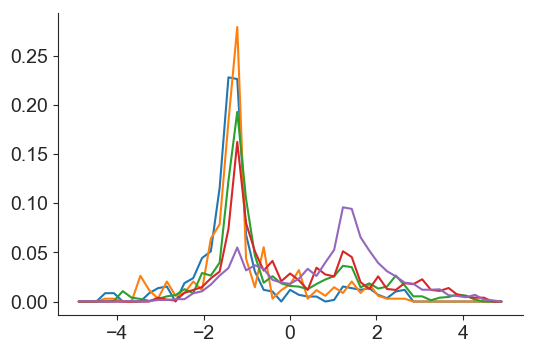

In [223]:
dx = 0.2
for ii, (dxbin0, dxbin1) in enumerate([(-1,-0.1), (-0.1, -.05),(-0.05,0.05),(0.05,0.1),(0.1,1)]): 
    global_hist = []
    for xbin in np.arange(0,1-dx, dx):
        x1,x2,x3 = delta_frequency_for_product.T
        ind = (x2<xbin+dx)&(x2>=xbin)&(x2-x1>=dxbin0)&(x2-x1<dxbin1)
        d = ((x3-x2)/x2/(1-x2))[ind]
        if xbin>0.15:
            global_hist.extend(d)
        f = delta_frequency_for_product[ind,0]
        print(xbin, dxbin0, (x3-x2)[ind].mean(), sum(ind), d.std())
        plt.figure(1)
        plt.plot(sorted(d),np.linspace(0,1,len(d)), c="C%d"%ii)
    plt.figure(1)
    plt.xlim([-5,5])
    y,x = np.histogram(global_hist, bins=np.linspace(-5,5,50))
    plt.figure(2)
    plt.plot((x[:-1]+x[1:])/2, y/y.sum(), label=str(xbin))

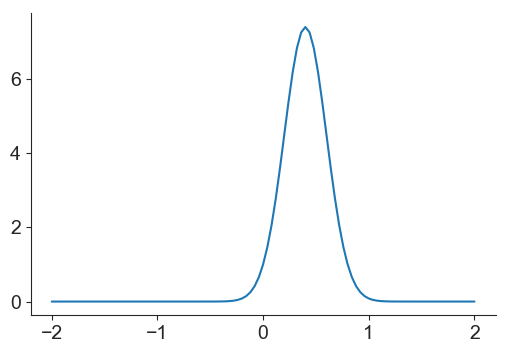

In [203]:
sigma=0.2
x=np.linspace(-2,2,101)
plt.plot(x, np.exp(-x**2/2/sigma**2)*np.exp(10*x))